# Loading the Modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Loading the Data

In [ ]:
active = pd.read_csv("active19-clean.csv", 
                     usecols=['Text','Date','Name','Location','search term','clean_text'])
active20 = pd.read_csv("active20-clean.csv", 
                     usecols=['Text','Date','Name','Location','search term','clean_text'])
active = active.append(active20)
active['type'] = 'active'
active.head()

In [ ]:
lazy = pd.read_csv("lazy19-clean.csv", 
                     usecols=['Text','Date','Name','Location','search term','clean_text'])
lazy20 = pd.read_csv("lazy20-clean.csv", 
                     usecols=['Text','Date','Name','Location','search term','clean_text'])
lazy = lazy.append(lazy20)
lazy['type']='lazy'

In [ ]:
df = active.append(lazy)

In [5]:
df.head()

,Text,Date,Name,Location,search term,clean_text,type
0,New #knife post on our forum! » New Opinel #6 ...,2019-03-24,mtjsblog,NaN,outdoor,new knife post forum new opinel httpstcoprbmwh...,active
1,New #shtf discussion on our forum! » https://t...,2019-03-18,mtjsblog,NaN,outdoor,new shtf discussion forum httpstcowzretpdwb,active
2,Good time this weekend with our @twistedtea @c...,2019-04-01,tydillon,"Welcome, North Carolina",outdoor,good time weekend twistedtea chevy texas call_...,active
3,Proud of GEICO’s dedication to NASCAR! https:/...,2019-03-25,tydillon,"Welcome, North Carolina",outdoor,proud geico dedication nascar httpstcouqxaszkrv,active
4,Summer is in the air! Call us to get started o...,2019-04-10,JSQimprovements,"Huntington Beach, CA",outdoor,summer air call us get started custom swimming...,active


# Naive Bayes Model

We decided to build a model that determines the most characteristic words of active or lazy users. We will use a Naive Bayes Multinomial Model to predict the type of the user. We want to predict a category with labelled data and over 100K samples of text data, so it is appropriate to use Naive Bayes as a model.

In [ ]:
# Store tweet dataset into feature matrix and response vector
X_words = df['clean_text']
y_words = df['type']

# Instantiate CountVectorizer and TfidfVectorizer
count_vect = CountVectorizer(min_df=1, ngram_range=(1, 2)) 
tfidf_vect = TfidfVectorizer(min_df=1, ngram_range=(1, 2))


# Apply CountVectorizer 
X_count = count_vect.fit_transform(df['clean_text'].apply(str))
X_count = X_count.tocsc() 

# Apply TfidfVectorizer
X_tfidf = tfidf_vect.fit_transform(df['clean_text'].apply(str))
X_tfidf = X_tfidf.tocsc()


# Split train/test data for all data
Xtrain_count, Xtest_count, ytrain_count, ytest_count = train_test_split(X_count, y_words, random_state=17)
Xtrain_tfidf, Xtest_tfidf, ytrain_tfidf, ytest_tfidf = train_test_split(X_tfidf, y_words, random_state=17)

In [8]:
def evaluate_model(xtest, ytest, clf):
    """ 
    This function evaluates the effectiveness of a ML model and outputs F1 Scores, AUC score and Confusion Matrix
    """
    # Make predictions for Xtest
    y_pred = clf.predict(xtest)
    
    # Confusion matrix
    cm = metrics.confusion_matrix(ytest, y_pred)
    
    print(classification_report(ytest, y_pred))
    print('\nConfusion Matrix:\n', cm)

In [ ]:
# Instantiate multinomialNB()
nb_words_count = MultinomialNB(alpha=1, fit_prior=True)
nb_words_tfidf = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb_words_count.fit(Xtrain_count, ytrain_count)
nb_words_tfidf.fit(Xtrain_tfidf, ytrain_tfidf)

In [9]:
evaluate_model(Xtest_count, ytest_count, nb_words_count)

              precision    recall  f1-score   support

      active       0.83      0.71      0.77     15523
        lazy       0.70      0.82      0.76     12657

    accuracy                           0.76     28180
   macro avg       0.76      0.77      0.76     28180
weighted avg       0.77      0.76      0.76     28180


Confusion Matrix:
 [[11080  4443]
 [ 2285 10372]]


The F1-score is 77%. The number of False Positives (2,285) is low compared to True Positives (11,080). True Negatives number (10,372) is also much higher than False Negatives (4,443).

In [10]:
evaluate_model(Xtest_tfidf, ytest_tfidf, nb_words_tfidf)

              precision    recall  f1-score   support

      active       0.71      0.90      0.79     15523
        lazy       0.81      0.54      0.65     12657

    accuracy                           0.74     28180
   macro avg       0.76      0.72      0.72     28180
weighted avg       0.75      0.74      0.73     28180


Confusion Matrix:
 [[13911  1612]
 [ 5789  6868]]


The F-1 score is 77%. The proportion for False Positives to True Positives and False Negatives to True Negatives stay around the same.

Overall we can conclude that the model is good, but we will try to tune in the hyperparameter alpha to make the predictions even better.

In [11]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': (1,0.1,0.01,0.001,2,5,10,25)} 

multinom_cv = GridSearchCV(nb_words_count, param_grid, cv=5, scoring='roc_auc') 
multinom_cv.fit(Xtrain_count, ytrain_count) 
multinom_cv.best_params_

{'alpha': 1}

In [12]:
multinom_cv.best_score_

0.8421094523447299

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': (1,0.1,0.01,0.001,2,5,10,25)} 

tdidf_multinom_cv = GridSearchCV(nb_words_tfidf, param_grid, cv=5, scoring='roc_auc') 
tdidf_multinom_cv.fit(Xtrain_tfidf, ytrain_tfidf) 
tdidf_multinom_cv.best_params_

{'alpha': 0.1}

In [14]:
tdidf_multinom_cv.best_score_

0.8480343803693777

The ROC-AUC score has improved to 84% for both models.

## Feature Importances

Let's review top 20 most important words for predicting the active users on twitter by using sklearn feature_importances_

In [14]:
#regular model feature importances
NB_optimal = MultinomialNB(alpha=1, fit_prior=True)
NB_optimal=NB_optimal.fit(X_count, y_words)
feature_names = count_vect.get_feature_names()

# model with Term Frequency feature importances
NBtdidf_optimal = MultinomialNB(alpha=0.1, fit_prior=True)
NBtdidf_optimal = NBtdidf_optimal.fit(X_tfidf, y_words)
feature_names_tdidf = tfidf_vect.get_feature_names()

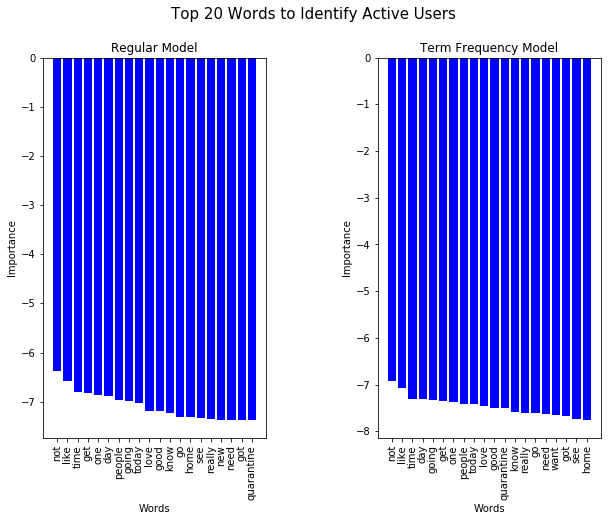

In [18]:
_ = plt.figure(figsize=(10,7))
_ = plt.suptitle('Top 20 Words to Identify Active Users', fontsize=15)

_ = plt.subplot(1,2,1)
for i in sorted(zip(NB_optimal.coef_[0], feature_names), reverse = True)[:20]:
    _ = plt.bar(i[1],i[0],color='blue')
    _ = plt.title('Regular Model')
    _ = plt.xlabel('Words')
    _ = plt.xticks(rotation=90)
    _ = plt.ylabel('Importance')
    #_ = plt.tight_layout(pad=2)

_ = plt.subplot(1,2,2)
for i in sorted(zip(NBtdidf_optimal.coef_[0], feature_names_tdidf), reverse = True)[:20]:
    _ = plt.bar(i[1],i[0], color='blue')
    _ = plt.title('Term Frequency Model')
    _ = plt.xlabel('Words')
    _ = plt.xticks(rotation=90)
    _ = plt.ylabel('Importance')

_ = plt.subplots_adjust(wspace = 0.5, hspace = 0.2)
_ = plt.savefig(fname='NB-Top Words')

The coef_ attribute of MultinomialNB is a re-parameterization of the naive Bayes model as a linear classifier model. For a binary classification problems this is basically the log of the estimated probability of a feature given the positive class. It means that higher values mean more important features for the positive class. <br>
In our case even the most highly rated words (features) have negative values, meaning that they are not highly predictive.

# Random Forest Model

In [96]:
# Instantiate and fit training data to Random Forest Model (CountVec)
forest_clf_count = RandomForestClassifier(class_weight='balanced',
                                     n_estimators=100, max_depth=5).fit(Xtrain_count, ytrain_count)

# Instantiate and fit training data to Random Forest Model (TFIDF Vec)
forest_clf_tfidf = RandomForestClassifier(class_weight='balanced',
                                     n_estimators=100, max_depth=5).fit(Xtrain_tfidf, ytrain_tfidf)

In [97]:
evaluate_model(Xtest_count, ytest_count, forest_clf_count)

              precision    recall  f1-score   support

      active       0.77      0.47      0.58     15523
        lazy       0.56      0.83      0.67     12657

    accuracy                           0.63     28180
   macro avg       0.67      0.65      0.63     28180
weighted avg       0.68      0.63      0.62     28180


Confusion Matrix:
 [[ 7247  8276]
 [ 2129 10528]]


In [98]:
evaluate_model(Xtest_tfidf, ytest_tfidf, forest_clf_tfidf)

              precision    recall  f1-score   support

      active       0.76      0.51      0.61     15523
        lazy       0.57      0.81      0.67     12657

    accuracy                           0.64     28180
   macro avg       0.67      0.66      0.64     28180
weighted avg       0.68      0.64      0.64     28180


Confusion Matrix:
 [[ 7861  7662]
 [ 2447 10210]]


In [9]:
# tune in hyperparameters
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [20,100]
             ,'max_depth': [3,5]}
             #,'min_samples_split': [2, 5]
             #,'min_samples_leaf': [1, 3]
             #,'min_weight_fraction_leaf': [0, 0.25]
             #,'max_features': [5, 10, 20]} 

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc') 
rf_cv.fit(Xtrain_count, ytrain_count) 
rf_cv.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [10]:
rf_cv.best_score_

0.706251993245407

In [11]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [20,100]
             ,'max_depth': [3, 5]}
             #,'min_samples_split': [2, 5]
             #,'min_samples_leaf': [1, 3]
             #,'min_weight_fraction_leaf': [0, 0.25]
             #,'max_features': [5, 10, 20]} 

rf = RandomForestClassifier()
rf_cv_tfidf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc') 
rf_cv_tfidf.fit(Xtrain_tfidf, ytrain_tfidf) 
rf_cv_tfidf.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [12]:
rf_cv_tfidf.best_score_

0.7102484257841393

In [13]:
#regular model feature importances
rf_optimal = RandomForestClassifier(n_estimators= 100, max_depth = 5)
rf_optimal=rf_optimal.fit(X_count, y_words)
feature_names = count_vect.get_feature_names()

# model with Term Frequency feature importances
rftdidf_optimal = RandomForestClassifier(n_estimators=100 , max_depth = 5)
rftdidf_optimal = rftdidf_optimal.fit(X_tfidf, y_words)
feature_names_tdidf = tfidf_vect.get_feature_names()

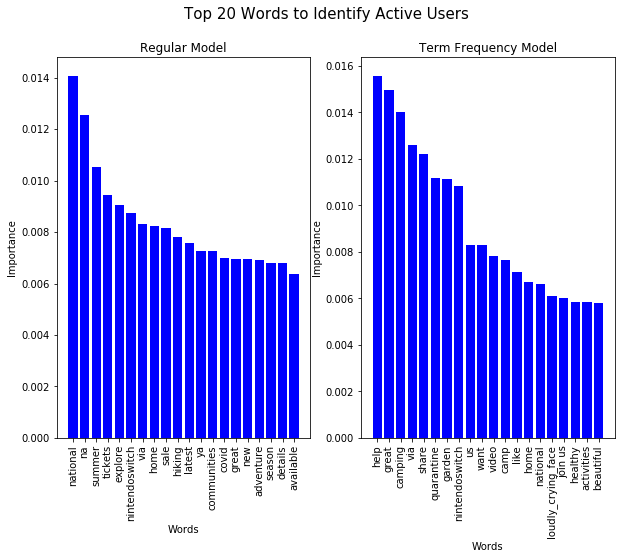

In [19]:
# plot top words 
_ = plt.figure(figsize=(10,7))
_ = plt.suptitle('Top 20 Words to Identify Active Users', fontsize=15)

_ = plt.subplot(1,2,1)
for i in sorted(zip(rf_optimal.feature_importances_,feature_names), reverse=True)[:20]:
    _ = plt.bar(i[1],i[0], color='blue')
    _ = plt.title('Regular Model')
    _ = plt.xlabel('Words')
    _ = plt.xticks(rotation=90)
    _ = plt.ylabel('Importance')
    #_ = plt.tight_layout(pad=2)

_ = plt.subplot(1,2,2)
for i in sorted(zip(rftdidf_optimal.feature_importances_, feature_names_tdidf), reverse=True)[:20]:
    _ = plt.bar(i[1],i[0], color='blue')
    _ = plt.title('Term Frequency Model')
    _ = plt.xlabel('Words')
    _ = plt.xticks(rotation=90)
    _ = plt.ylabel('Importance')

_ = plt.subplots_adjust(wspace = 0.2, hspace = 0.2)
_ = plt.savefig(fname='NB-Top Words')